## Importing libraries and Installing packages


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras_preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import seaborn as sn

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading dataset

In [ ]:
sexism_dataset = pd.read_csv("train_all_tasks.csv")
print("Shape of training data = ", sexism_dataset.shape)
sexism_dataset.sample(10)

Shape of training data =  (14000, 5)


,rewire_id,text,label_sexist,label_category,label_vector
7894,sexism2022_english-4647,The problem that was being addressed here was ...,not sexist,none,none
13108,sexism2022_english-8720,Male feminists are the new anti-gay preachers....,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,..."
6429,sexism2022_english-16927,"""Journalists"" to the rescue! [The internet exp...",not sexist,none,none
11076,sexism2022_english-5362,Not this shit again Jesus.,not sexist,none,none
10251,sexism2022_english-19684,"Sorry, but ""trans men"" don't exist, just cospl...",not sexist,none,none
7979,sexism2022_english-18618,hateful fuckn witch bitch,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,..."
11243,sexism2022_english-10677,Jersey girls/boys have annoying accents and st...,not sexist,none,none
5823,sexism2022_english-17971,"It's really sad actually, I've heard about his...",not sexist,none,none
4615,sexism2022_english-1806,"The only ""single moms"" I don't look sideways a...",sexist,2. derogation,2.2 aggressive and emotive attacks
12055,sexism2022_english-7960,Im being discharged tomorrow! Fuck Yeaaah,not sexist,none,none


In [ ]:
# Checking for missing values

sexism_dataset.isnull().values.any()

False

<Axes: xlabel='label_sexist', ylabel='count'>

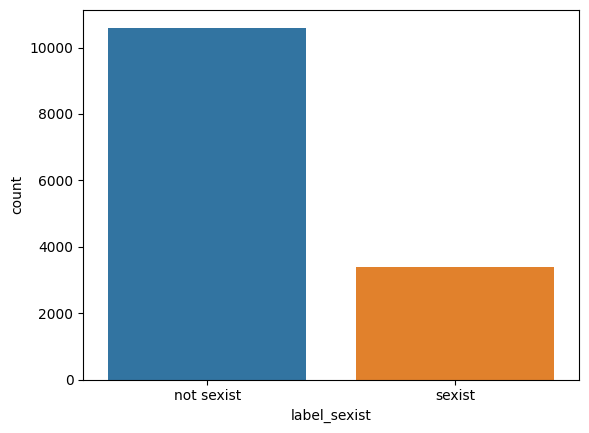

In [ ]:
# Observing class balance

import seaborn as sns
sns.countplot(x='label_sexist', data=sexism_dataset)

## Data Preprocessing

In [ ]:
# Dropping all columns except text and label_sexist

sexism_dataset=sexism_dataset.drop(['rewire_id','label_category', 'label_vector'], axis=1)
sexism_dataset.sample(10)

,text,label_sexist
3948,"Sounds just like another fucking Moslem to me,...",sexist
12815,I and a lot of people give a fuck that we had ...,not sexist
5952,I'm surprised no one has attempted to punch th...,not sexist
5550,Brother.. she likes you,not sexist
5873,"""Earn"" women lol. Just buy hookers pls.",not sexist
8480,a man wouldn't dare complain about a woman rec...,not sexist
12687,I think a lack of a mom would do the similar t...,not sexist
5445,What is the point in showing a sketch of her? ...,not sexist
12464,I was reading that exchange ... and thinking t...,not sexist
8036,This always reminds me of the woman that will ...,not sexist


In [ ]:
# Cleaning the data and remmoving unnecessary stuff

def preprocess_text(sen):

    # Lowercasing sentence
    sentence = sen.lower()

    # Removing html tags
    TAG_RE = re.compile(r'<[^>]+>')
    sentence = TAG_RE.sub('', sentence)

    # Removing punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Removing single character 
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  

    # Removing Stopwords
    # pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    # sentence = pattern.sub('', sentence)

    return sentence

sexism_dataset['cleaned_text'] = sexism_dataset['text'].apply(preprocess_text)  
sexism_dataset.sample(10)

,text,label_sexist,cleaned_text
13836,female egg donors are allowed to be uggo as fu...,sexist,female egg donors are allowed to be uggo as fu...
13607,"Good question, probably thots in training... i...",sexist,good question probably thots in training if we...
11906,Have you asked it? Have you? Typical huMAN.,not sexist,have you asked it have you typical human
2186,Behind every great man is a great woman. And t...,sexist,behind every great man is great woman and that...
1133,You mean she falls in love with someone she fi...,not sexist,you mean she falls in love with someone she fi...
8011,What other books you can suggest that made an ...,not sexist,what other books you can suggest that made an ...
4632,A woman forces Larry to dance and tries to dro...,not sexist,a woman forces larry to dance and tries to dro...
5010,DiScRiMiNaTiOn,not sexist,discrimination
11238,The privileges they'd get with having a captiv...,not sexist,the privileges they get with having captive wi...
4394,Talk to a girl as if she isn't a potential mat...,sexist,talk to girl as if she isn a potential mate th...


In [ ]:
# Label Binarization -> sexist=1, not sexist=0

sexism_dataset['binary_label_sexist']=sexism_dataset['label_sexist'].apply(lambda x: 1 if x=='sexist' else 0)
sexism_dataset.sample(10)

,text,label_sexist,cleaned_text,binary_label_sexist
5289,"Yes, this will certainly bring down Trump.",not sexist,yes this will certainly bring down trump,0
2374,all the barren 40-something white cat ladies m...,sexist,all the barren something white cat ladies must...,1
4994,so your mom's a janitor?,not sexist,so your mom a janitor,0
2775,[USER] That's the funniest shit I've ever read...,not sexist,user that the funniest shit ve ever read and ...,0
12457,Someone please take this broad and stick her i...,sexist,someone please take this broad and stick her i...,1
1432,Another executive order. Another assault on th...,not sexist,another executive order another assault on the...,0
13060,"^ ""OP is lying about son's suicide and iz bitt...",not sexist,op is lying about son suicide and iz bitter n...,0
1863,She is a loon Putin should turn up at number 1...,sexist,she is loon putin should turn up at number and...,1
5611,Realise that she thinks of you as an acquainta...,not sexist,realise that she thinks of you as an acquainta...,0
13088,He should bang his girlfriend.,not sexist,he should bang his girlfriend,0


In [ ]:
# Word Frequency Analysis

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sexism_dataset['cleaned_text'])
word_counts = tokenizer.word_counts

# Remove stop words
stop_words = set(stopwords.words('english'))
word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

# Sort the words by frequency
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the top words and their frequencies
top_words = sorted_words[:10]
word_labels = [word[0] for word in top_words]
word_freqs = [word[1] for word in top_words]

# Visualize the results
plt.bar(word_labels, word_freqs)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Frequency')
plt.show()

In [ ]:
# Splitting our dataset into train(70%), val(15%) and test(15%)

X_trainval, X_test, y_trainval, y_test = train_test_split(sexism_dataset['cleaned_text'], sexism_dataset['binary_label_sexist'], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.176, random_state=42)

In [ ]:
# Calculate the proportions of each set

train_prop = len(X_train) / len(sexism_dataset['cleaned_text'])
val_prop = len(X_val) / len(sexism_dataset['cleaned_text'])
test_prop = len(X_test) / len(sexism_dataset['cleaned_text'])

# Print the proportions
print("Training set proportion: {:.2f}".format(train_prop))
print("Validation set proportion: {:.2f}".format(val_prop))
print("Test set proportion: {:.2f}".format(test_prop))

Training set proportion: 0.70
Validation set proportion: 0.15
Test set proportion: 0.15


## Preparing embedding layer

In [ ]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length  #number of unique words

17093

In [ ]:
# Padding all comment sentences to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all unique words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

##Training with CNN

In [ ]:
from keras.layers import Conv1D
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [ ]:
# Defining Model Architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1709300   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,773,557
Trainable params: 64,257
Non-trainable params: 1,709,300
_________________________________________________________________
None


In [ ]:
# Model Training

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
cnn_model_history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
154/154 [==============================] - 19s 96ms/step - loss: 0.5082 - acc: 0.7698 - val_loss: 0.4880 - val_acc: 0.7704
Epoch 2/20
154/154 [==============================] - 8s 49ms/step - loss: 0.3985 - acc: 0.8275 - val_loss: 0.4342 - val_acc: 0.8124
Epoch 3/20
154/154 [==============================] - 10s 64ms/step - loss: 0.3400 - acc: 0.8587 - val_loss: 0.4216 - val_acc: 0.8220
Epoch 4/20
154/154 [==============================] - 8s 53ms/step - loss: 0.2915 - acc: 0.8845 - val_loss: 0.4151 - val_acc: 0.8277
Epoch 5/20
154/154 [==============================] - 9s 60ms/step - loss: 0.2361 - acc: 0.9189 - val_loss: 0.4445 - val_acc: 0.8248
Epoch 6/20
154/154 [==============================] - 10s 65ms/step - loss: 0.1902 - acc: 0.9436 - val_loss: 0.4383 - val_acc: 0.8267
Epoch 7/20
154/154 [==============================] - 8s 49ms/step - loss: 0.1519 - acc: 0.9626 - val_loss: 0.4429 - val_acc: 0.8243


In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

66/66 [==============================] - 1s 11ms/step - loss: 0.4241 - acc: 0.8205


66/66 [==============================] - 1s 17ms/step


Text(50.722222222222214, 0.5, 'Truth')

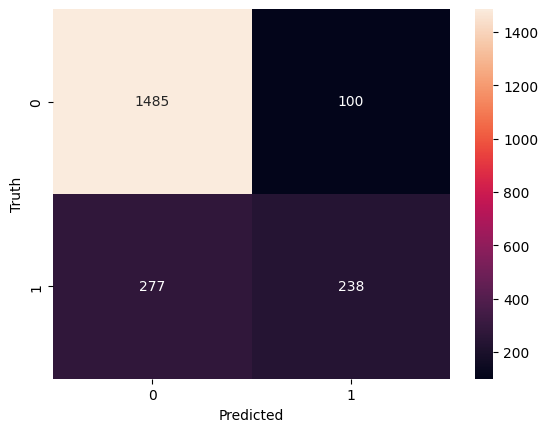

In [ ]:
# Model Performance

from sklearn.metrics import confusion_matrix, classification_report
import sys
import numpy as np

np.set_printoptions(threshold=sys.maxsize)
y_pred = cnn_model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

cm=confusion_matrix(y_test,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1585
           1       0.70      0.46      0.56       515

    accuracy                           0.82      2100
   macro avg       0.77      0.70      0.72      2100
weighted avg       0.81      0.82      0.81      2100



## Training with Bidirectional LSTM


In [ ]:
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

In [ ]:
# Defining Model Architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(128,activation='relu')))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1709300   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,944,053
Trainable params: 234,753
Non-trainable params: 1,709,300
_________________________________________________________________
None


In [ ]:
# Model Training

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
lstm_model_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
154/154 [==============================] - 90s 562ms/step - loss: 1.1762 - acc: 0.7523 - val_loss: 0.5149 - val_acc: 0.7575
Epoch 2/20
154/154 [==============================] - 70s 456ms/step - loss: 0.9199 - acc: 0.7886 - val_loss: 0.4608 - val_acc: 0.8010
Epoch 3/20
154/154 [==============================] - 72s 470ms/step - loss: 0.4234 - acc: 0.8192 - val_loss: 0.4357 - val_acc: 0.8143
Epoch 4/20
154/154 [==============================] - 76s 495ms/step - loss: 0.3946 - acc: 0.8314 - val_loss: 0.4040 - val_acc: 0.8282
Epoch 5/20
154/154 [==============================] - 76s 494ms/step - loss: 0.3754 - acc: 0.8411 - val_loss: 0.4088 - val_acc: 0.8358
Epoch 6/20
154/154 [==============================] - 78s 504ms/step - loss: 0.3561 - acc: 0.8475 - val_loss: 0.3924 - val_acc: 0.8344
Epoch 7/20
154/154 [==============================] - 75s 489ms/step - loss: 0.4601 - acc: 0.8207 - val_loss: 0.4371 - val_acc: 0.8048
Epoch 8/20
154/154 [==============================] - 7

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

66/66 [==============================] - 6s 87ms/step - loss: 0.4088 - acc: 0.8143


66/66 [==============================] - 7s 108ms/step


Text(50.722222222222214, 0.5, 'Truth')

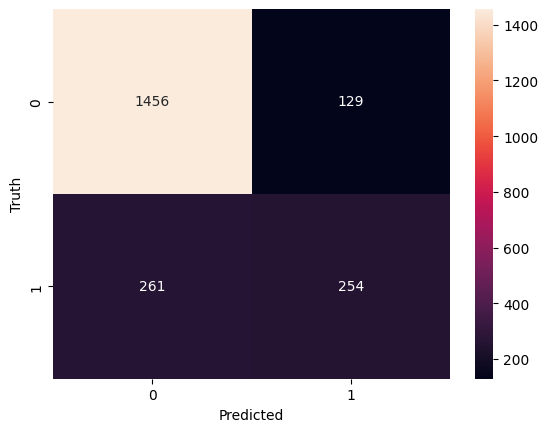

In [ ]:
# Model Performance

from sklearn.metrics import confusion_matrix, classification_report
import sys
import numpy as np

np.set_printoptions(threshold=sys.maxsize)
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

cm=confusion_matrix(y_test,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1585
           1       0.66      0.49      0.57       515

    accuracy                           0.81      2100
   macro avg       0.76      0.71      0.72      2100
weighted avg       0.80      0.81      0.80      2100



## Training with GRU

In [ ]:
from keras.layers import GRU

In [ ]:
# Defining Model Architecture

gru_model = Sequential()
gru_model.add(Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
gru_model.add(GRU(256, activation='relu')),
gru_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model Compiling

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(gru_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1709300   
                                                                 
 gru_1 (GRU)                 (None, 256)               274944    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,984,501
Trainable params: 275,201
Non-trainable params: 1,709,300
_________________________________________________________________
None


In [ ]:
# Model Training

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
gru_model_history = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=20, verbose=1, callbacks=[early_stopping])

Epoch 1/20
154/154 [==============================] - 67s 424ms/step - loss: 0.6386 - acc: 0.7582 - val_loss: 0.5566 - val_acc: 0.7556
Epoch 2/20
154/154 [==============================] - 70s 452ms/step - loss: 0.5536 - acc: 0.7582 - val_loss: 0.5562 - val_acc: 0.7556
Epoch 3/20
154/154 [==============================] - 63s 408ms/step - loss: 0.5504 - acc: 0.7582 - val_loss: 0.5498 - val_acc: 0.7556
Epoch 4/20
154/154 [==============================] - 70s 456ms/step - loss: 0.5436 - acc: 0.7582 - val_loss: 0.5476 - val_acc: 0.7556
Epoch 5/20
154/154 [==============================] - 65s 424ms/step - loss: 0.5229 - acc: 0.7588 - val_loss: 0.4958 - val_acc: 0.7785
Epoch 6/20
154/154 [==============================] - 69s 445ms/step - loss: 0.4288 - acc: 0.8145 - val_loss: 0.4231 - val_acc: 0.8210
Epoch 7/20
154/154 [==============================] - 64s 415ms/step - loss: 0.4042 - acc: 0.8277 - val_loss: 0.4194 - val_acc: 0.8282
Epoch 8/20
154/154 [==============================] - 6

In [ ]:
# Predictions on the Test Set

score = gru_model.evaluate(X_test, y_test, verbose=1)

66/66 [==============================] - 6s 94ms/step - loss: 0.4112 - acc: 0.8252


66/66 [==============================] - 7s 103ms/step


Text(50.722222222222214, 0.5, 'Truth')

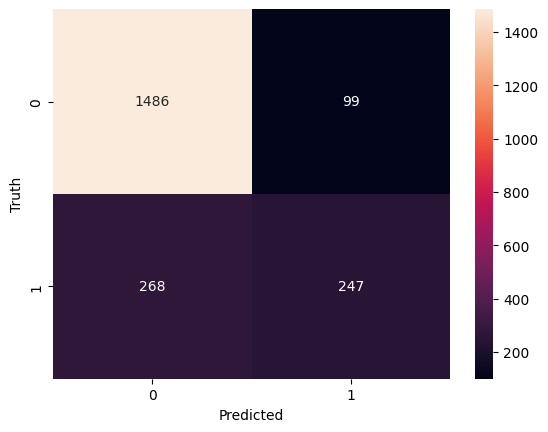

In [ ]:
# Model Performance

from sklearn.metrics import confusion_matrix, classification_report
import sys
import numpy as np

np.set_printoptions(threshold=sys.maxsize)
y_pred = gru_model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

cm=confusion_matrix(y_test,y_pred)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1585
           1       0.71      0.48      0.57       515

    accuracy                           0.83      2100
   macro avg       0.78      0.71      0.73      2100
weighted avg       0.81      0.83      0.81      2100

